In [1]:
import sys
sys.path.append('..')
from keras.optimizers import Adam
import numpy as np
import dicom
import os 
import cv2
import shutil

from unet_builder import UnetBuilder
from utils import bce_dice_loss, dice_coef, dice_loss
from data_generator import DataGenerator
import plot_helpers as ph
import utils

from keras.initializers import Orthogonal, glorot_normal, he_normal
from keras.regularizers import l2, l1

Using TensorFlow backend.


KeyboardInterrupt: 

In [2]:
!ls trained_models/

m_33M-0_pruned.json		    weights_1_a.h5
optimizer_1_a.pkl		    weights_1a-do-aug-run0.h5
optimizer_1a-do-aug-run0.pkl	    weights_1a-do-aug-run1.h5
optimizer_1a-do-aug-run1.pkl	    weights_1a-do-run0.h5
optimizer_1a-do-run0.pkl	    weights_1a-do-run1.h5
optimizer_1a-do-run1.pkl	    weights_1a-do-run2.h5
optimizer_1a-do-run2.pkl	    weights_1a-do-run3.h5
optimizer_1a-do-run3.pkl	    weights_1a-do-run4.h5
optimizer_1a-do-run4.pkl	    weights_1a-do-run5.h5
optimizer_1a-do-run5.pkl	    weights_1a-do-run6.h5
optimizer_1a-do-run6.pkl	    weights_1a-do-run7.h5
optimizer_1a-do-run7.pkl	    weights_1a-do-run8.h5
optimizer_1a-do-run8.pkl	    weights_1a-do-run9.h5
optimizer_1a-do-run9.pkl	    weights_1c_long-do-run0.h5
optimizer_1c_long-do-run0.pkl	    weights_1c_long-do-run1.h5
optimizer_1c_long-do-run1.pkl	    weights_1c_long-do-run2.h5
optimizer_1c_long-do-run2.pkl	    weights_1c_long-do-run3.h5
optimizer_1c_long-do-run3.pkl	    weights_1c_long-do-run4.h5
optimizer_1c_long-do-run4.pkl	    weig

### Prepare DataLoader and U-Net

In [3]:
model_name = '1_a'
models_dir = './trained_models/'
batch_size = 4

unet_layer_filters = [8, 16, 32, 64, 128]#[64, 128, 256, 512, 1024]# 
dropout = True
batch_norm = False

n_gpus = utils.device_config(verbose=False)
kernel_initializer = Orthogonal
kernel_init_seed = 42
kernel_regularizer = l2
weight_decay = 1e-4


print ("Using {} GPUs".format(n_gpus))

Using 1 GPUs


In [4]:
data_root = '/oasis/projects/nsf/csd538/mhnguyen/project-share/ucsd-medical/data/preprocessed/'
data_dir = os.path.join(data_root, '2wk_baseline_full_cardiac_cycle_176_npy') #adler_176_npy')#
dim=(176,176,1)
data_gen = DataGenerator([data_dir], batch_size=batch_size, p_sample=0.25, dim=dim[:-1])

print("Building U-Net (parallelizing to {} GPUs)...".format(n_gpus))
model_builder = UnetBuilder(dim,
                            unet_layer_filters, 
                            dropout=dropout, 
                            batch_norm=batch_norm,
                            kernel_initializer=kernel_initializer,
                            kernel_init_seed=kernel_init_seed,
                            kernel_regularizer=kernel_regularizer,
                            weight_decay=weight_decay,
                            #more_decoding=[2],
                            output_activation='sigmoid',
                            n_gpus=n_gpus)

model = model_builder.build()
model.compile(optimizer=Adam(lr=0.005), 
              loss=bce_dice_loss,  
              metrics=[bce_dice_loss, dice_coef])

print("Loading trained model ({})...".format(model_name))
model = utils.load_model_state(model, model_name, models_dir)

print("Done.")

Finished loading: 250 batches, 1000 samples
Building U-Net (parallelizing to 1 GPUs)...
Loading trained model (1_a)...
Done.


### Make Predictions
Inspect in network (preprocessed) dimensions

In [5]:
probs = model.predict(data_gen.load_all())
predictions = np.where(probs > 0.5, 1, 0).reshape(len(probs),176, 176, 1)

ValueError: No data provided for "input_1". Need data for each key in: ['input_1']

859_Slice 6_MRIm01_image.npy (Batch 1492: Image 1)


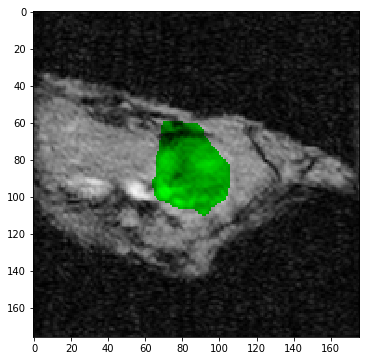

In [331]:
batch_num = np.random.randint(0, len(data_gen))
i = np.random.randint(0, batch_size)

image_batch, _ = data_gen[batch_num]


image = image_batch[i][:,:,0]
ctr_pred = predictions[batch_size * batch_num + i][:,:,0]
fname = data_gen._image_fnames[batch_size * batch_num + i].split('/')[-1]

print("{} (Batch {}: Image {})".format(fname, batch_num, i))
ph.overlay_contour(image, ctr_pred)

### Transform masks back to original dimensions

In [96]:
def un_preprocess(mask, dcm):
    """ Return mask to original image dimensions """
    if mask.ndim > 2: mask = mask[:,:,0]
    pad_rows = (dcm.Rows//2 - mask.shape[0])//2
    pad_cols = (dcm.Columns//2 - mask.shape[1])//2
    padding = ((pad_rows, pad_rows),(pad_cols, pad_cols))
    mask = np.pad(mask, padding, 'constant')
    mask = cv2.resize(mask.astype(np.uint16), (0, 0), fx=2, fy=2)
    return mask    


def decompose_fname(fname):
    if '/' in fname:
        fname = fname.split('/')[-1]
        
    patient = fname.split('_Slice')[0]
    slice_name = fname.split(patient + '_')[1].split('_')[0]
    frame = fname.split(slice_name + '_')[-1].split('_image.npy')[0]
    return patient, slice_name, frame

def load_original(preprocessed_fname, og_dir):
    """ Get original image from dicom source """
    
    patient, slice_name, frame = decompose_fname(preprocessed_fname)    
    og_path = os.path.join(og_dir, patient, slice_name, frame)
    
    return dicom.read_file(og_path).pixel_array.astype('float')


In [97]:
og_dir = '/oasis/projects/nsf/csd538/mhnguyen/shared/ucsd_cardiology/data/mice-data/full_cardiac_cycle/2wk_baseline_fcc'

predictions = [un_preprocess(mask, data_gen.get_metadata(fname)) 
               for mask, fname in zip(predictions, data_gen._image_fnames)]

(384, 512) (384, 512)
/oasis/projects/nsf/csd538/mhnguyen/project-share/ucsd-medical/data/preprocessed/2wk_baseline_full_cardiac_cycle_176_npy/247_2wk_Slice 11_MRIm19_image.npy (Image 1241)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


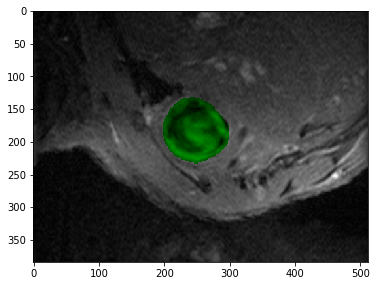

In [98]:
i = np.random.randint(0, len(predictions))

ctr_pred = predictions[i]

fname = data_gen._image_fnames[i]
image = load_original(fname, og_dir) 

min_px = np.min(image)
image -= min_px
image /= (np.max(image) - min_px)
print(image.shape, ctr_pred.shape)

print("{} (Image {})".format(fname, i))
ph.overlay_contour(image, ctr_pred)

### Write to files

Using same structure as original DICOM source

In [100]:
def write_out(out_dir, overwrite=False):
    
    if os.path.exists(out_dir):
        if overwrite:
            shutil.rmtree(out_dir)
        else:
            raise IOError('{} already exists, exiting'.format(out_dir))
    else:
        print("Creating {}".format(out_dir))    
        os.makedirs(out_dir)
    
    
    for i, ctr_pred in enumerate(predictions):

        pp_fname = data_gen._image_fnames[i]
        patient, slice_name, frame = decompose_fname(pp_fname)

        slice_dir = os.path.join(OUT_DIR, patient, slice_name)
        frame_path = os.path.join(slice_dir, frame)

        if os.path.exists(frame_path):
            if not overwrite:
                raise IOError('{} already exists, exiting'.format(frame_path))

        if not os.path.exists(slice_dir):
            os.makedirs(slice_dir)

        print(i, '\t', patient, slice_name, frame)    
        np.save(frame_path, ctr_pred)

In [101]:
OUT_DIR = og_dir + '_predictions'

write_out(OUT_DIR, overwrite=True)

0 	 239_2wk Slice 7 MRIm08
1 	 245_2wk Slice 9 MRIm01
2 	 251_2wk Slice 8 MRIm17
3 	 225_2wk Slice 8 MRIm18
4 	 245_2wk Slice 10 MRIm11
5 	 235_2wk Slice 2 MRIm20
6 	 241_2wk Slice 1 MRIm10
7 	 233_2wk Slice 11 MRIm08
8 	 222_2wk Slice 8 MRIm19
9 	 240_2wk Slice 10.1 MRIm15
10 	 225_2wk Slice 2 MRIm08
11 	 241_2wk Slice 5 MRIm14
12 	 237_2wk Slice 7 MRIm19
13 	 223_2wk Slice 9 MRIm20
14 	 245_2wk Slice 3 MRIm04
15 	 237_2wk Slice 7 MRIm13
16 	 233_2wk Slice 6 MRIm02
17 	 223_2wk Slice 1 MRIm16
18 	 245_2wk Slice 2 MRIm15
19 	 251_2wk Slice 3 MRIm17
20 	 251_2wk Slice 7 MRIm17
21 	 247_2wk Slice 7 MRIm13
22 	 228_2wk Slice 8 MRIm16
23 	 250_2wk Slice 11 MRIm19
24 	 222_2wk Slice 1 MRIm08
25 	 222_2wk Slice 7 MRIm16
26 	 247_2wk Slice 7 MRIm07
27 	 245_2wk Slice 6 MRIm14
28 	 229_2wk Slice 1 MRIm15
29 	 250_2wk Slice 1 MRIm12
30 	 240_2wk Slice 2.1 MRIm02
31 	 251_2wk Slice 8 MRIm01
32 	 251_2wk Slice 9 MRIm18
33 	 223_2wk Slice 6 MRIm11
34 	 251_2wk Slice 4 MRIm04
35 	 247_2wk Slice 2 M

322 	 224_2wk Slice 1 MRIm02
323 	 224_2wk Slice 9 MRIm12
324 	 250_2wk Slice 6 MRIm02
325 	 245_2wk Slice 9 MRIm18
326 	 237_2wk Slice 1 MRIm03
327 	 235_2wk Slice 2 MRIm09
328 	 237_2wk Slice 8 MRIm01
329 	 222_2wk Slice 10 MRIm15
330 	 250_2wk Slice 10 MRIm07
331 	 244_2wk Slice 10 MRIm14
332 	 228_2wk Slice 1 MRIm11
333 	 224_2wk Slice 6 MRIm08
334 	 247_2wk Slice 10 MRIm13
335 	 235_2wk Slice 7 MRIm09
336 	 233_2wk Slice 2 MRIm04
337 	 250_2wk Slice 8 MRIm07
338 	 250_2wk Slice 1 MRIm11
339 	 224_2wk Slice 6 MRIm07
340 	 240_2wk Slice 10.1 MRIm07
341 	 228_2wk Slice 5 MRIm18
342 	 244_2wk Slice 5 MRIm15
343 	 225_2wk Slice 6 MRIm08
344 	 223_2wk Slice 2 MRIm14
345 	 229_2wk Slice 1 MRIm04
346 	 251_2wk Slice 10 MRIm08
347 	 225_2wk Slice 7 MRIm05
348 	 236_2wk Slice 3 MRIm04
349 	 222_2wk Slice 10 MRIm12
350 	 228_2wk Slice 6 MRIm17
351 	 236_2wk Slice 1 MRIm16
352 	 251_2wk Slice 4 MRIm17
353 	 246_2wk Slice 1 MRIm03
354 	 223_2wk Slice 6 MRIm05
355 	 223_2wk Slice 3 MRIm05
356 	

624 	 244_2wk Slice 5 MRIm20
625 	 245_2wk Slice 2 MRIm05
626 	 229_2wk Slice 7 MRIm08
627 	 228_2wk Slice 6 MRIm15
628 	 250_2wk Slice 5 MRIm09
629 	 246_2wk Slice 9 MRIm12
630 	 250_2wk Slice 5 MRIm13
631 	 236_2wk Slice 9 MRIm18
632 	 251_2wk Slice 4 MRIm06
633 	 240_2wk Slice 5.1 MRIm10
634 	 245_2wk Slice 1 MRIm07
635 	 223_2wk Slice 8 MRIm15
636 	 250_2wk Slice 11 MRIm10
637 	 229_2wk Slice 4 MRIm16
638 	 240_2wk Slice 2.1 MRIm20
639 	 222_2wk Slice 10 MRIm13
640 	 228_2wk Slice 10 MRIm08
641 	 224_2wk Slice 8 MRIm08
642 	 244_2wk Slice 5 MRIm09
643 	 240_2wk Slice 9.1 MRIm12
644 	 233_2wk Slice 6 MRIm15
645 	 233_2wk Slice 10 MRIm20
646 	 251_2wk Slice 10 MRIm20
647 	 224_2wk Slice 5 MRIm09
648 	 245_2wk Slice 1 MRIm01
649 	 247_2wk Slice 4 MRIm08
650 	 240_2wk Slice 5.1 MRIm17
651 	 237_2wk Slice 6 MRIm18
652 	 228_2wk Slice 8 MRIm20
653 	 247_2wk Slice 7 MRIm06
654 	 225_2wk Slice 1 MRIm05
655 	 250_2wk Slice 2 MRIm01
656 	 244_2wk Slice 9 MRIm16
657 	 246_2wk Slice 7 MRIm07
6

931 	 241_2wk Slice 9 MRIm06
932 	 224_2wk Slice 4 MRIm03
933 	 251_2wk Slice 7 MRIm02
934 	 236_2wk Slice 6 MRIm16
935 	 251_2wk Slice 6 MRIm20
936 	 247_2wk Slice 10 MRIm04
937 	 250_2wk Slice 1 MRIm14
938 	 229_2wk Slice 2 MRIm05
939 	 250_2wk Slice 8 MRIm02
940 	 223_2wk Slice 3 MRIm01
941 	 224_2wk Slice 6 MRIm17
942 	 244_2wk Slice 6 MRIm15
943 	 237_2wk Slice 2 MRIm17
944 	 229_2wk Slice 3 MRIm05
945 	 235_2wk Slice 10 MRIm01
946 	 222_2wk Slice 3 MRIm02
947 	 244_2wk Slice 7 MRIm20
948 	 246_2wk Slice 2 MRIm19
949 	 223_2wk Slice 2 MRIm09
950 	 222_2wk Slice 3 MRIm17
951 	 251_2wk Slice 4 MRIm03
952 	 223_2wk Slice 5 MRIm16
953 	 244_2wk Slice 3 MRIm20
954 	 239_2wk Slice 2 MRIm09
955 	 235_2wk Slice 2 MRIm05
956 	 250_2wk Slice 1 MRIm04
957 	 223_2wk Slice 1 MRIm17
958 	 224_2wk Slice 4 MRIm19
959 	 223_2wk Slice 6 MRIm18
960 	 224_2wk Slice 1 MRIm03
961 	 250_2wk Slice 1 MRIm19
962 	 246_2wk Slice 5 MRIm13
963 	 247_2wk Slice 12 MRIm15
964 	 224_2wk Slice 6 MRIm13
965 	 237_2

1231 	 224_2wk Slice 6 MRIm06
1232 	 247_2wk Slice 8 MRIm19
1233 	 245_2wk Slice 4 MRIm14
1234 	 251_2wk Slice 2 MRIm15
1235 	 251_2wk Slice 11 MRIm14
1236 	 241_2wk Slice 5 MRIm04
1237 	 223_2wk Slice 2 MRIm15
1238 	 229_2wk Slice 4 MRIm18
1239 	 222_2wk Slice 10 MRIm04
1240 	 239_2wk Slice 2 MRIm04
1241 	 247_2wk Slice 11 MRIm19
1242 	 241_2wk Slice 1 MRIm11
1243 	 246_2wk Slice 4 MRIm10
1244 	 244_2wk Slice 5 MRIm10
1245 	 241_2wk Slice 1 MRIm16
1246 	 237_2wk Slice 2 MRIm16
1247 	 228_2wk Slice 11 MRIm10
1248 	 229_2wk Slice 3 MRIm15
1249 	 245_2wk Slice 5 MRIm16
1250 	 224_2wk Slice 2 MRIm08
1251 	 235_2wk Slice 10 MRIm03
1252 	 247_2wk Slice 4 MRIm07
1253 	 240_2wk Slice 5.1 MRIm04
1254 	 244_2wk Slice 2 MRIm18
1255 	 236_2wk Slice 4 MRIm15
1256 	 229_2wk Slice 9 MRIm11
1257 	 222_2wk Slice 3 MRIm05
1258 	 240_2wk Slice 2.1 MRIm11
1259 	 235_2wk Slice 2 MRIm16
1260 	 244_2wk Slice 11 MRIm19
1261 	 223_2wk Slice 9 MRIm06
1262 	 239_2wk Slice 5 MRIm12
1263 	 240_2wk Slice 7.1 MRIm0

1550 	 236_2wk Slice 6 MRIm18
1551 	 229_2wk Slice 5 MRIm11
1552 	 247_2wk Slice 9 MRIm19
1553 	 229_2wk Slice 6 MRIm06
1554 	 250_2wk Slice 4 MRIm10
1555 	 239_2wk Slice 6 MRIm09
1556 	 233_2wk Slice 11 MRIm03
1557 	 244_2wk Slice 5 MRIm14
1558 	 236_2wk Slice 9 MRIm01
1559 	 250_2wk Slice 9 MRIm07
1560 	 228_2wk Slice 2 MRIm17
1561 	 233_2wk Slice 6 MRIm19
1562 	 245_2wk Slice 10 MRIm02
1563 	 223_2wk Slice 1 MRIm10
1564 	 223_2wk Slice 1 MRIm05
1565 	 224_2wk Slice 2 MRIm12
1566 	 250_2wk Slice 3 MRIm19
1567 	 251_2wk Slice 10 MRIm01
1568 	 228_2wk Slice 9 MRIm12
1569 	 246_2wk Slice 4 MRIm15
1570 	 237_2wk Slice 3 MRIm11
1571 	 223_2wk Slice 6 MRIm13
1572 	 223_2wk Slice 7 MRIm07
1573 	 250_2wk Slice 5 MRIm02
1574 	 247_2wk Slice 10 MRIm19
1575 	 241_2wk Slice 4 MRIm13
1576 	 240_2wk Slice 8.1 MRIm18
1577 	 245_2wk Slice 8 MRIm04
1578 	 244_2wk Slice 8 MRIm16
1579 	 246_2wk Slice 10 MRIm04
1580 	 229_2wk Slice 1 MRIm17
1581 	 222_2wk Slice 9 MRIm18
1582 	 222_2wk Slice 8 MRIm06
158

1841 	 225_2wk Slice 3 MRIm16
1842 	 224_2wk Slice 1 MRIm12
1843 	 224_2wk Slice 5 MRIm03
1844 	 222_2wk Slice 11 MRIm06
1845 	 236_2wk Slice 5 MRIm04
1846 	 233_2wk Slice 2 MRIm15
1847 	 229_2wk Slice 3 MRIm10
1848 	 239_2wk Slice 8 MRIm06
1849 	 244_2wk Slice 3 MRIm12
1850 	 244_2wk Slice 10 MRIm19
1851 	 244_2wk Slice 10 MRIm07
1852 	 247_2wk Slice 4 MRIm18
1853 	 247_2wk Slice 7 MRIm16
1854 	 236_2wk Slice 4 MRIm13
1855 	 244_2wk Slice 4 MRIm02
1856 	 244_2wk Slice 3 MRIm13
1857 	 241_2wk Slice 7 MRIm19
1858 	 233_2wk Slice 11 MRIm15
1859 	 237_2wk Slice 2 MRIm12
1860 	 246_2wk Slice 5 MRIm16
1861 	 228_2wk Slice 11 MRIm13
1862 	 250_2wk Slice 4 MRIm08
1863 	 246_2wk Slice 2 MRIm20
1864 	 229_2wk Slice 8 MRIm12
1865 	 241_2wk Slice 11 MRIm06
1866 	 223_2wk Slice 4 MRIm08
1867 	 236_2wk Slice 9 MRIm20
1868 	 224_2wk Slice 8 MRIm17
1869 	 241_2wk Slice 9 MRIm18
1870 	 228_2wk Slice 9 MRIm18
1871 	 251_2wk Slice 7 MRIm10
1872 	 229_2wk Slice 9 MRIm07
1873 	 240_2wk Slice 1.1 MRIm19
18

2146 	 237_2wk Slice 5 MRIm11
2147 	 251_2wk Slice 11 MRIm08
2148 	 222_2wk Slice 9 MRIm05
2149 	 250_2wk Slice 7 MRIm12
2150 	 244_2wk Slice 1 MRIm07
2151 	 236_2wk Slice 9 MRIm17
2152 	 251_2wk Slice 10 MRIm18
2153 	 244_2wk Slice 2 MRIm14
2154 	 241_2wk Slice 9 MRIm10
2155 	 233_2wk Slice 12 MRIm05
2156 	 247_2wk Slice 2 MRIm06
2157 	 241_2wk Slice 10 MRIm08
2158 	 245_2wk Slice 8 MRIm18
2159 	 250_2wk Slice 8 MRIm13
2160 	 236_2wk Slice 5 MRIm20
2161 	 222_2wk Slice 11 MRIm05
2162 	 224_2wk Slice 2 MRIm18
2163 	 247_2wk Slice 5 MRIm05
2164 	 224_2wk Slice 4 MRIm16
2165 	 237_2wk Slice 2 MRIm07
2166 	 223_2wk Slice 2 MRIm12
2167 	 228_2wk Slice 4 MRIm14
2168 	 241_2wk Slice 5 MRIm06
2169 	 237_2wk Slice 6 MRIm05
2170 	 236_2wk Slice 6 MRIm12
2171 	 241_2wk Slice 5 MRIm07
2172 	 223_2wk Slice 3 MRIm12
2173 	 244_2wk Slice 5 MRIm12
2174 	 235_2wk Slice 2 MRIm08
2175 	 247_2wk Slice 1 MRIm05
2176 	 244_2wk Slice 8 MRIm04
2177 	 235_2wk Slice 1 MRIm19
2178 	 245_2wk Slice 4 MRIm15
2179 

2451 	 244_2wk Slice 9 MRIm15
2452 	 244_2wk Slice 2 MRIm07
2453 	 241_2wk Slice 1 MRIm01
2454 	 245_2wk Slice 3 MRIm19
2455 	 250_2wk Slice 3 MRIm10
2456 	 233_2wk Slice 3 MRIm13
2457 	 223_2wk Slice 10 MRIm04
2458 	 222_2wk Slice 11 MRIm18
2459 	 235_2wk Slice 9 MRIm03
2460 	 223_2wk Slice 10 MRIm13
2461 	 236_2wk Slice 4 MRIm19
2462 	 245_2wk Slice 6 MRIm19
2463 	 246_2wk Slice 11 MRIm14
2464 	 244_2wk Slice 4 MRIm07
2465 	 223_2wk Slice 8 MRIm14
2466 	 237_2wk Slice 1 MRIm04
2467 	 237_2wk Slice 4 MRIm02
2468 	 228_2wk Slice 9 MRIm16
2469 	 240_2wk Slice 1.1 MRIm05
2470 	 237_2wk Slice 4 MRIm10
2471 	 244_2wk Slice 7 MRIm11
2472 	 236_2wk Slice 9 MRIm10
2473 	 241_2wk Slice 6 MRIm13
2474 	 247_2wk Slice 2 MRIm18
2475 	 241_2wk Slice 6 MRIm19
2476 	 235_2wk Slice 7 MRIm03
2477 	 241_2wk Slice 8 MRIm10
2478 	 250_2wk Slice 10 MRIm18
2479 	 228_2wk Slice 4 MRIm04
2480 	 247_2wk Slice 4 MRIm16
2481 	 250_2wk Slice 5 MRIm04
2482 	 247_2wk Slice 5 MRIm06
2483 	 241_2wk Slice 9 MRIm12
248

2756 	 251_2wk Slice 11 MRIm20
2757 	 229_2wk Slice 7 MRIm17
2758 	 245_2wk Slice 3 MRIm11
2759 	 233_2wk Slice 10 MRIm01
2760 	 250_2wk Slice 8 MRIm03
2761 	 229_2wk Slice 1 MRIm20
2762 	 245_2wk Slice 4 MRIm13
2763 	 240_2wk Slice 4.1 MRIm08
2764 	 239_2wk Slice 3 MRIm05
2765 	 222_2wk Slice 5 MRIm16
2766 	 246_2wk Slice 8 MRIm07
2767 	 246_2wk Slice 3 MRIm18
2768 	 233_2wk Slice 12 MRIm16
2769 	 241_2wk Slice 7 MRIm06
2770 	 237_2wk Slice 3 MRIm07
2771 	 233_2wk Slice 5 MRIm19
2772 	 240_2wk Slice 9.1 MRIm05
2773 	 224_2wk Slice 5 MRIm18
2774 	 241_2wk Slice 12 MRIm06
2775 	 228_2wk Slice 6 MRIm20
2776 	 228_2wk Slice 4 MRIm18
2777 	 233_2wk Slice 7 MRIm03
2778 	 241_2wk Slice 7 MRIm16
2779 	 228_2wk Slice 5 MRIm03
2780 	 229_2wk Slice 3 MRIm11
2781 	 247_2wk Slice 6 MRIm15
2782 	 240_2wk Slice 9.1 MRIm10
2783 	 229_2wk Slice 5 MRIm06
2784 	 237_2wk Slice 3 MRIm15
2785 	 229_2wk Slice 5 MRIm08
2786 	 250_2wk Slice 10 MRIm12
2787 	 228_2wk Slice 5 MRIm11
2788 	 250_2wk Slice 3 MRIm13

3035 	 223_2wk Slice 5 MRIm07
3036 	 237_2wk Slice 2 MRIm15
3037 	 251_2wk Slice 3 MRIm12
3038 	 241_2wk Slice 2 MRIm09
3039 	 228_2wk Slice 7 MRIm20
3040 	 228_2wk Slice 2 MRIm03
3041 	 240_2wk Slice 4.1 MRIm01
3042 	 239_2wk Slice 6 MRIm07
3043 	 244_2wk Slice 6 MRIm20
3044 	 244_2wk Slice 1 MRIm01
3045 	 233_2wk Slice 6 MRIm01
3046 	 247_2wk Slice 3 MRIm15
3047 	 245_2wk Slice 8 MRIm06
3048 	 245_2wk Slice 4 MRIm19
3049 	 245_2wk Slice 11 MRIm20
3050 	 237_2wk Slice 6 MRIm16
3051 	 235_2wk Slice 1 MRIm05
3052 	 222_2wk Slice 4 MRIm01
3053 	 247_2wk Slice 7 MRIm17
3054 	 240_2wk Slice 3.1 MRIm04
3055 	 222_2wk Slice 5 MRIm13
3056 	 225_2wk Slice 9 MRIm17
3057 	 244_2wk Slice 8 MRIm17
3058 	 251_2wk Slice 11 MRIm12
3059 	 228_2wk Slice 8 MRIm02
3060 	 245_2wk Slice 7 MRIm16
3061 	 250_2wk Slice 1 MRIm01
3062 	 223_2wk Slice 1 MRIm07
3063 	 223_2wk Slice 10 MRIm17
3064 	 229_2wk Slice 4 MRIm02
3065 	 237_2wk Slice 8 MRIm03
3066 	 250_2wk Slice 5 MRIm10
3067 	 233_2wk Slice 12 MRIm20
30

3338 	 235_2wk Slice 5 MRIm01
3339 	 224_2wk Slice 2 MRIm01
3340 	 250_2wk Slice 1 MRIm20
3341 	 236_2wk Slice 9 MRIm04
3342 	 245_2wk Slice 3 MRIm05
3343 	 228_2wk Slice 2 MRIm12
3344 	 240_2wk Slice 8.1 MRIm16
3345 	 244_2wk Slice 1 MRIm09
3346 	 237_2wk Slice 2 MRIm04
3347 	 237_2wk Slice 9 MRIm14
3348 	 246_2wk Slice 7 MRIm08
3349 	 236_2wk Slice 2 MRIm19
3350 	 224_2wk Slice 8 MRIm10
3351 	 241_2wk Slice 7 MRIm13
3352 	 247_2wk Slice 1 MRIm06
3353 	 233_2wk Slice 2 MRIm06
3354 	 224_2wk Slice 9 MRIm10
3355 	 225_2wk Slice 4 MRIm04
3356 	 239_2wk Slice 7 MRIm05
3357 	 237_2wk Slice 8 MRIm06
3358 	 229_2wk Slice 3 MRIm19
3359 	 240_2wk Slice 3.1 MRIm13
3360 	 237_2wk Slice 4 MRIm03
3361 	 224_2wk Slice 2 MRIm03
3362 	 240_2wk Slice 1.1 MRIm01
3363 	 228_2wk Slice 9 MRIm04
3364 	 244_2wk Slice 3 MRIm06
3365 	 235_2wk Slice 7 MRIm16
3366 	 225_2wk Slice 3 MRIm01
3367 	 247_2wk Slice 10 MRIm02
3368 	 225_2wk Slice 5 MRIm03
3369 	 239_2wk Slice 7 MRIm19
3370 	 237_2wk Slice 9 MRIm07
337

3639 	 240_2wk Slice 6.1 MRIm14
3640 	 233_2wk Slice 9 MRIm05
3641 	 244_2wk Slice 11 MRIm18
3642 	 247_2wk Slice 9 MRIm02
3643 	 241_2wk Slice 9 MRIm15
3644 	 239_2wk Slice 2 MRIm18
3645 	 240_2wk Slice 8.1 MRIm13
3646 	 228_2wk Slice 10 MRIm11
3647 	 239_2wk Slice 8 MRIm13
3648 	 247_2wk Slice 9 MRIm18
3649 	 244_2wk Slice 4 MRIm20
3650 	 247_2wk Slice 10 MRIm18
3651 	 247_2wk Slice 10 MRIm12
3652 	 235_2wk Slice 4 MRIm09
3653 	 241_2wk Slice 3 MRIm07
3654 	 246_2wk Slice 10 MRIm13
3655 	 247_2wk Slice 6 MRIm19
3656 	 225_2wk Slice 4 MRIm13
3657 	 240_2wk Slice 9.1 MRIm01
3658 	 237_2wk Slice 8 MRIm05
3659 	 228_2wk Slice 10 MRIm09
3660 	 239_2wk Slice 7 MRIm11
3661 	 240_2wk Slice 2.1 MRIm14
3662 	 251_2wk Slice 2 MRIm05
3663 	 251_2wk Slice 10 MRIm02
3664 	 233_2wk Slice 5 MRIm14
3665 	 244_2wk Slice 4 MRIm03
3666 	 228_2wk Slice 2 MRIm09
3667 	 235_2wk Slice 6 MRIm04
3668 	 240_2wk Slice 1.1 MRIm06
3669 	 251_2wk Slice 6 MRIm08
3670 	 235_2wk Slice 10 MRIm07
3671 	 245_2wk Slice 1

3923 	 246_2wk Slice 7 MRIm06
3924 	 233_2wk Slice 3 MRIm15
3925 	 246_2wk Slice 10 MRIm16
3926 	 241_2wk Slice 7 MRIm20
3927 	 236_2wk Slice 5 MRIm07
3928 	 228_2wk Slice 8 MRIm06
3929 	 229_2wk Slice 6 MRIm13
3930 	 250_2wk Slice 3 MRIm01
3931 	 228_2wk Slice 7 MRIm19
3932 	 245_2wk Slice 6 MRIm17
3933 	 245_2wk Slice 1 MRIm05
3934 	 241_2wk Slice 7 MRIm08
3935 	 241_2wk Slice 9 MRIm05
3936 	 233_2wk Slice 7 MRIm01
3937 	 250_2wk Slice 1 MRIm03
3938 	 250_2wk Slice 8 MRIm14
3939 	 240_2wk Slice 4.1 MRIm18
3940 	 225_2wk Slice 2 MRIm20
3941 	 223_2wk Slice 1 MRIm13
3942 	 244_2wk Slice 3 MRIm01
3943 	 223_2wk Slice 5 MRIm12
3944 	 222_2wk Slice 11 MRIm20
3945 	 223_2wk Slice 7 MRIm13
3946 	 241_2wk Slice 7 MRIm12
3947 	 225_2wk Slice 1 MRIm12
3948 	 245_2wk Slice 1 MRIm14
3949 	 245_2wk Slice 4 MRIm01
3950 	 241_2wk Slice 10 MRIm06
3951 	 240_2wk Slice 1.1 MRIm13
3952 	 245_2wk Slice 5 MRIm03
3953 	 237_2wk Slice 6 MRIm14
3954 	 244_2wk Slice 5 MRIm17
3955 	 233_2wk Slice 8 MRIm01
395

### Verify Saves


In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

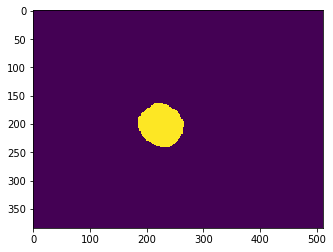

In [103]:
example = os.path.join(OUT_DIR,'251_2wk/Slice 10/MRIm12.npy')
img = np.load(example)
plt.imshow(img)

In [ ]:
def show_batch(X, Y,overlay_masks=True, nrows=1, **kwargs):
    """ Displays a batch as a grid of images """

    augs = []
    row_step =1
    bs = 4
    ncols = bs // nrows

    figsize = (7*bs, 10*nrows)
    imgsize = (figsize[0]/nrows, figsize[1]/ncols)

    plt.gray()  
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    grid = plt.GridSpec(nrows, ncols, fig)#, hspace=0.1, wspace=0.1)      

    for r in range(0, nrows, row_step):
        for c in range(ncols):
            #title = patient_name(fnames[r+c][0])
            #title += aug_name(r+c) if augs else ''                
            ax = fig.add_subplot(grid[r, c])
            #ax.set_title(title, fontsize=32)
            ax.set_yticks([])
            ax.set_xticks([])               
            img = X[r+c,:,:,0]
            mask = Y[r+c,:,:,0]
            if overlay_masks:
                img_masked = ph.overlay_contour(img, mask, vis=False)
                ax.imshow(img_masked, aspect='equal')

            else:
                ax.imshow(img, aspect='equal')
    if 'savefig' in kwargs:
        plt.savefig(kwargs['savefig'], dpi=400)

    plt.show();